<a href="https://colab.research.google.com/github/SEC-API-io/sec-api-cookbook/blob/main/notebooks/form-8k/8k-item-5-02-tutorial-website.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Analysis of Officer and Director Change Reports

We illustrate how to perform an exploratory data analysis on disclosures informing investors about changes of certain officers and directors of publicly traded companies on U.S. stock exchanges. These changes are disclosed in Form 8-K filings with the SEC, specifically under Item 5.02, titled "Departure of Directors or Certain Officers; Election of Directors; Appointment of Certain Officers: Compensatory Arrangements of Certain Officers." These disclosures are presented in text form by companies. Utilizing our Structured Data API, we extract and structure the relevant information from the text, making it available for detailed analysis.

Our analysis will focus on several key areas:

- Number of Item 5.02 disclosures made each year from 2004 to 2024, per quarter, month and at what time of the day (pre-market, regular market, after-market)
- Distribution of disclosures across structured data fields, such as the proportion of disclosures reporting appointments and departures.
- Appointments: number per year to certain position and statistics such as histograms of the age of the appointed person and the annual compensation.
- Departures: number per per year and their reasons and the rate if disagreements in connection with these departures.
- Amendments: distribution of amendments across term duration change, compensation changes and compensation types.
- Changes of the Board of Directors size
- Eligibility of bonus plans

## Data Loading and Preparation

To load and prepare the data, we will use the [Form 8-K Item 5.02 Structured Data API](https://sec-api.io/docs/form-8k-data-item5-2-search-api) to download all structured data related to Form 8-K filings that include Item 5.02 disclosures. For the sake of brevity, the data about spanning the years 2004 to 2024 has already been preprocessed, the personnel changes list exploded and the entries stored at the root level, and saved in a CSV file, allowing us to jump directly into the analysis phase.

We will first focus on the personnel change data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick
import seaborn as sns


style.use("default")

params = {
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "font.family": "sans-serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.color": "grey",
    "axes.grid": True,
    "axes.grid.axis": "y",
    "grid.alpha": 0.5,
    "grid.linestyle": ":",
}

plt.rcParams.update(params)

In [57]:
# data loading goes here

unique_years = structured_data["year"].nunique()
unique_companies = structured_data["companyName"].nunique()
unique_filings = structured_data["accessionNo"].nunique()
min_year = structured_data["year"].min()
max_year = structured_data["year"].max()
print("Loaded dataframe with structured personnel change data from Form 8-K Item 5.02 filings")
print(f"Number of filings: {unique_filings:,}")
print(f"Number of records: {len(structured_data):,}")
print(f"Number of years: {unique_years:,} ({min_year}-{max_year})")
print(f"Number of unique companies: {unique_companies:,}")

structured_data.head()

Loaded dataframe with structured personnel change data from Form 8-K Item 5.02 filings
Number of filings: 250,418
Number of records: 473,492
Number of years: 21 (2004-2024)
Number of unique companies: 24,847


,accessionNo,filedAt,periodOfReport,formType,cik,ticker,companyName,items,type,departureType,...,consultingEndDate,person.familyRelationships,amendmentSummary,oldTermEndDate,year,month,qtr,filedAt_local,filedAtClass,dayOfWeek
0,0001125282-04-004109,2004-08-23T09:51:12-04:00,2004-08-23,8-K,1022671,STLD,STEEL DYNAMICS INC,['Item 5.02: Departure of Directors or Certain...,departure,resignation,...,NaN,NaN,NaN,NaN,2004,8,3,2004-08-23 09:51:12,marketHours,Mon
1,0001125282-04-004109,2004-08-23T09:51:12-04:00,2004-08-23,8-K,1022671,STLD,STEEL DYNAMICS INC,['Item 5.02: Departure of Directors or Certain...,appointment,NaN,...,NaN,NaN,NaN,NaN,2004,8,3,2004-08-23 09:51:12,marketHours,Mon
2,0001104659-04-025282,2004-08-23T11:31:33-04:00,2004-08-23,8-K,1038363,NaN,METALS USA INC,['Item 5.02: Departure of Directors or Certain...,departure,retirement,...,NaN,NaN,NaN,NaN,2004,8,3,2004-08-23 11:31:33,marketHours,Mon
3,0001104659-04-025282,2004-08-23T11:31:33-04:00,2004-08-23,8-K,1038363,NaN,METALS USA INC,['Item 5.02: Departure of Directors or Certain...,appointment,NaN,...,NaN,NaN,NaN,NaN,2004,8,3,2004-08-23 11:31:33,marketHours,Mon
4,0000899715-04-000164,2004-08-23T12:35:47-04:00,2004-08-23,8-K,899715,SKT,TANGER FACTORY OUTLET CENTERS INC,['Item 5.02: Departure of Directors or Certain...,appointment,NaN,...,NaN,NaN,NaN,NaN,2004,8,3,2004-08-23 12:35:47,marketHours,Mon


## Vizualization of Officer and Director Change Disclosures over Time


In [4]:
item_5_02_counts = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["year"])
    .size()
    .to_frame(name="count")
)

print(f"Item 5.02 counts from 2004 to 2024.")
item_5_02_counts.T

Item 5.02 counts from 2004 to 2024.


year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
count,2988,9805,11441,17137,17590,14566,13294,13237,12832,12586,...,12612,11618,11353,11172,10976,10721,11456,11342,11044,9738


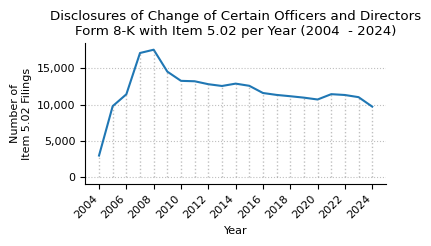

In [5]:
def plot_timeseries(ts, title):
    fig, ax = plt.subplots(figsize=(4, 2.5))
    ts["count"].plot(ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of\nItem 5.02 Filings")
    ax.set_xticks(np.arange(2004, 2025, 2))
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax.set_xlim(2003, 2025)
    ax.grid(axis="x")
    ax.set_axisbelow(True)
    plt.xticks(rotation=45, ha="right")

    for year in range(2004, 2025, 1):
        year_y_max = ts.loc[year, "count"]
        ax.vlines(year, 0, year_y_max, linestyles=":", colors="grey", alpha=0.5, lw=1)

    plt.tight_layout()
    plt.show()


plot_timeseries(
    item_5_02_counts,
    title="Disclosures of Change of Certain Officers and Directors\nForm 8-K with Item 5.02 per Year (2004  - 2024)",
)

In [6]:
structured_data["qtr"] = structured_data["month"].apply(lambda x: (x - 1) // 3 + 1)

counts_qtr_yr_piv = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["year", "qtr"])
    .size()
    .unstack()
    .fillna(0)
).astype(int)

# print(f"Item 5.02 counts by quarter from 2004 to 2024.")
# counts_qtr_yr_piv.T

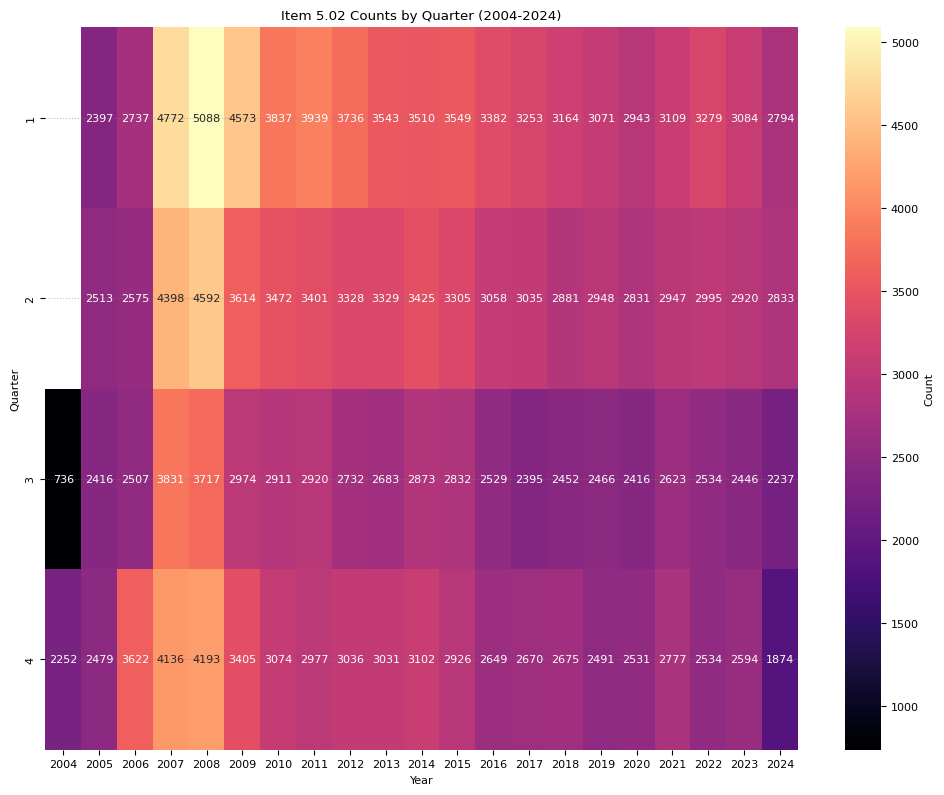

In [59]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    counts_qtr_yr_piv.T,
    annot=True,  # Display the cell values
    fmt="d",  # Integer formatting
    cmap="magma",  # Color map
    cbar_kws={"label": "Count"},  # Colorbar label
    mask=counts_qtr_yr_piv.T == 0,  # Mask the cells with value 0
)
plt.title("Item 5.02 Counts by Quarter (2004-2024)")
plt.xlabel("Year")
plt.ylabel("Quarter")
plt.tight_layout()
plt.show()

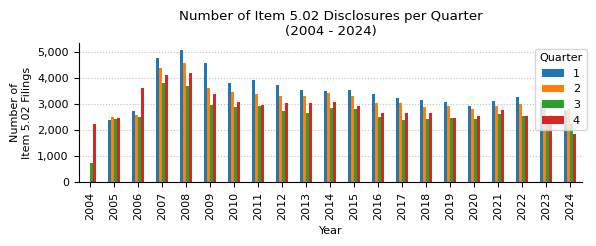

In [58]:
counts_qtr_yr = counts_qtr_yr_piv.stack().reset_index(name="count")

fig, ax = plt.subplots(figsize=(6, 2.5))
counts_qtr_yr_piv.plot(kind="bar", ax=ax, legend=True)
ax.legend(title="Quarter", loc="upper right", bbox_to_anchor=(1.02, 1))
ax.set_title("Number of Item 5.02 Disclosures per Quarter\n(2004 - 2024)")
ax.set_xlabel("Year")
ax.set_ylabel("Number of\nItem 5.02 Filings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

In [9]:
counts_month_yr_piv = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["year", "month"])
    .size()
    .unstack()
    .fillna(0)
).astype(int)

# print(f"Item 5.02 counts by month from 2004 to 2024.")
# counts_month_yr_piv

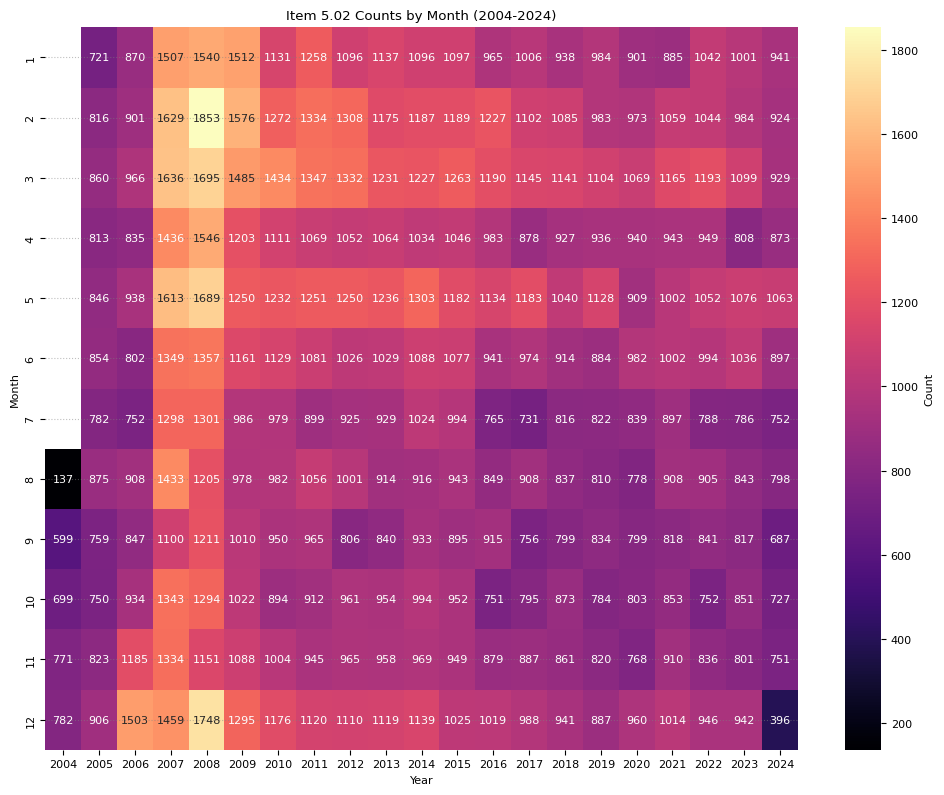

In [10]:
# Plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    counts_month_yr_piv.T,
    annot=True,  # Display the cell values
    fmt="d",  # Integer formatting
    cmap="magma",  # Color map
    cbar_kws={"label": "Count"},  # Colorbar label
    mask=counts_month_yr_piv.T == 0,  # Mask the cells with value 0
)
plt.title("Item 5.02 Counts by Month (2004-2024)")
plt.xlabel("Year")
plt.ylabel("Month")
plt.tight_layout()
plt.show()

In [11]:
print(f"Descriptive statistics for Item 5.02 counts by month from 2004 to 2024.")
month_stats = (
    counts_month_yr_piv.loc[2004:]
    .describe(percentiles=[0.025, 0.975])
    .round(0)
    .astype(int)
)
month_stats

Descriptive statistics for Item 5.02 counts by month from 2004 to 2024.


month,1,2,3,4,5,6,7,8,9,10,11,12
count,21,21,21,21,21,21,21,21,21,21,21,21
mean,1030,1125,1167,974,1113,980,860,904,866,900,936,1070
std,320,363,341,291,326,265,253,229,135,168,151,278
min,0,0,0,0,0,0,0,137,599,699,751,396
2.5%,360,408,430,404,423,401,366,458,643,713,760,589
50%,1006,1102,1190,949,1134,1002,839,908,840,873,910,1019
97.5%,1526,1741,1666,1491,1651,1353,1300,1319,1156,1318,1260,1626
max,1540,1853,1695,1546,1689,1357,1301,1433,1211,1343,1334,1748


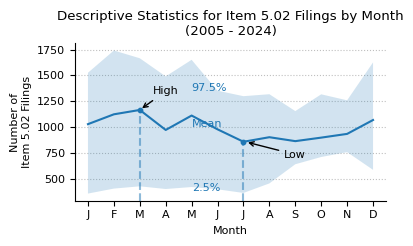

In [12]:
def plot_box_plot_as_line(
    data: pd.DataFrame,
    x_months=True,
    title="",
    x_label="",
    x_pos_mean_label=2,
    pos_labels=None,  # {"mean": {"x": 2, "y": 150}, "upper": {"x": 2, "y": 150}, "lower": {"x": 2, "y": 150}},
    pos_high_low=None,  # {"high": {"x": 2, "y": 150}, "low": {"x": 2, "y": 150}},
    y_label="",
    y_formatter=lambda x, p: "{:.0f}".format(int(x) / 1000),
    show_high_low_labels=True,
    show_inline_labels=True,
    show_bands=True,
    figsize=(4, 2.5),
    line_source="mean",
):
    fig, ax = plt.subplots(figsize=figsize)

    line_to_plot = data[line_source]
    lower_label = "2.5%"
    upper_label = "97.5%"
    lower = data[lower_label]
    upper = data[upper_label]

    line_to_plot.plot(ax=ax)

    if show_bands:
        ax.fill_between(line_to_plot.index, lower, upper, alpha=0.2)

    if x_months:
        ax.set_xlim(0.5, 12.5)
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(y_formatter))
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

    ymin, ymax = ax.get_ylim()
    y_scale = ymax - ymin

    max_x = int(line_to_plot.idxmax())
    max_y = line_to_plot.max()
    min_x = int(line_to_plot.idxmin())
    min_y = line_to_plot.min()

    ax.axvline(
        max_x,
        ymin=0,
        ymax=((max_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(max_x, max_y, color="tab:blue", s=10)
    ax.axvline(
        min_x,
        ymin=0,
        ymax=((min_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(min_x, min_y, color="tab:blue", s=10)

    x_pos_mean_label_int = int(x_pos_mean_label)
    if show_inline_labels:
        mean_x = x_pos_mean_label
        mean_y = line_to_plot.iloc[x_pos_mean_label_int] * 1.02
        upper_x = x_pos_mean_label
        upper_y = upper.iloc[x_pos_mean_label_int]
        lower_x = x_pos_mean_label
        lower_y = lower.iloc[x_pos_mean_label_int] * 0.95

        if pos_labels:
            mean_x = pos_labels["mean"]["x"]
            mean_y = pos_labels["mean"]["y"]
            upper_x = pos_labels["upper"]["x"]
            upper_y = pos_labels["upper"]["y"]
            lower_x = pos_labels["lower"]["x"]
            lower_y = pos_labels["lower"]["y"]

        ax.text(mean_x, mean_y, "Mean", color="tab:blue", fontsize=8)
        ax.text(upper_x, upper_y, upper_label, color="tab:blue", fontsize=8)
        ax.text(lower_x, lower_y, lower_label, color="tab:blue", fontsize=8)

    if show_high_low_labels:
        high_x_origin = max_x
        high_y_origin = max_y
        high_x_label = high_x_origin + 0.5
        high_y_label = high_y_origin + 0.1 * y_scale
        if pos_high_low:
            high_x_label = pos_high_low["high"]["x"]
            high_y_label = pos_high_low["high"]["y"]
        ax.annotate(
            "High",
            (high_x_origin, high_y_origin),
            xytext=(high_x_label, high_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

        low_x_origin = min_x * 1.01
        low_y_origin = min_y
        low_x_label = low_x_origin + 1.5
        low_y_label = low_y_origin - 0.1 * y_scale
        if pos_high_low:
            low_x_label = pos_high_low["low"]["x"]
            low_y_label = pos_high_low["low"]["y"]
        ax.annotate(
            "Low",
            (low_x_origin, low_y_origin),
            xytext=(low_x_label, low_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

    ax.grid(axis="x")
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()


plot_box_plot_as_line(
    data=month_stats.T,
    title="Descriptive Statistics for Item 5.02 Filings by Month\n(2005 - 2024)",
    x_label="Month",
    y_label="Number of\nItem 5.02 Filings",
    y_formatter=lambda x, p: "{:.0f}".format(int(x)),
    x_pos_mean_label=5,
)

In [13]:
counts_filedAtClass = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["filedAtClass"])
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Count")
).rename_axis("Publication Time")
counts_filedAtClass["Pct"] = (
    counts_filedAtClass["Count"].astype(int)
    / counts_filedAtClass["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_filedAtClass["Count"] = counts_filedAtClass["Count"].map(lambda x: f"{x:,}")
counts_filedAtClass.index = (
    counts_filedAtClass.index.str.replace("preMarket", "Pre-Market (4:00 - 9:30 AM)")
    .str.replace("marketHours", "Market Hours (9:30 AM - 4:00 PM)")
    .str.replace("afterMarket", "After Market (4:00 - 8:00 PM)")
)
counts_filedAtClass = counts_filedAtClass.reindex(counts_filedAtClass.index[::-1])

print(
    f"Item 5.02 counts by pre-market, regular market hours,\nand after-market publication time (2004 - 2024)."
)
counts_filedAtClass

Item 5.02 counts by pre-market, regular market hours,
and after-market publication time (2004 - 2024).


,Count,Pct
Publication Time,,
other,"4,212",2%
Pre-Market (4:00 - 9:30 AM),"30,906",12%
Market Hours (9:30 AM - 4:00 PM),"68,866",28%
After Market (4:00 - 8:00 PM),"146,434",58%


In [14]:
structured_data.loc[:, "dayOfWeek"] = structured_data["filedAt_local"].dt.strftime("%a")

counts_dayOfWeek = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["dayOfWeek"])
    .size()
    .to_frame(name="Count")
).rename_axis("Day of the Week")
counts_dayOfWeek["Pct"] = (
    counts_dayOfWeek["Count"].astype(int) / counts_dayOfWeek["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_dayOfWeek["Count"] = counts_dayOfWeek["Count"].map(lambda x: f"{x:,}")

print(f"Item 5.02 disclosures by day of the week (2004 - 2024).")
counts_dayOfWeek.loc[["Mon", "Tue", "Wed", "Thu", "Fri"]]

Item 5.02 disclosures by day of the week (2004 - 2024).


,Count,Pct
Day of the Week,,
Mon,"46,691",19%
Tue,"50,544",20%
Wed,"47,302",19%
Thu,"50,658",20%
Fri,"55,221",22%


## Type of Personnel Change


In [15]:
changeType = structured_data["type"].explode().value_counts().to_frame()
changeType.index.name = "Personnel Change Type"
changeType.columns = ["Count"]
changeType["Pct."] = changeType["Count"] / changeType["Count"].sum() * 100
changeType["Pct."] = changeType["Pct."].round(1)
changeType["Count"] = changeType["Count"].apply(lambda x: f"{x:,.0f}")

print(
    f"Opinion types of the audit reports if stated in the Item 5.02 filings (2004 - 2024):"
)
changeType

Opinion types of the audit reports if stated in the Item 5.02 filings (2004 - 2024):


,Count,Pct.
Personnel Change Type,,
appointment,"209,736",47.6
departure,"178,385",40.5
amendment,"41,789",9.5
bonus,"8,963",2.0
nomination,"1,903",0.4
refusal,219,0.0


In [ ]:
change_type_year = structured_data[["type", "year", "accessionNo"]]
changeType_year_pivot = pd.pivot_table(
    change_type_year,
    index="type",
    columns="year",
    values="accessionNo",
    aggfunc="count",
    fill_value=0,
)

changeType_year_pivot["total"] = changeType_year_pivot.sum(axis=1)
changeType_year_pivot = changeType_year_pivot.sort_values(by="total", ascending=False)
# remove artifacts
changeType_year_pivot = changeType_year_pivot[changeType_year_pivot["total"] >= 18]

changeType_year_pivot

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,total
type,,,,,,,,,,,,,,,,,,,,,
appointment,3132,10089,11466,13076,12841,10552,10678,10718,10365,10075,...,9603,9306,9455,9390,8975,11357,9713,9356,8126,209736
departure,2273,7731,8578,11211,11687,9800,9031,9247,8901,8731,...,8472,8243,8169,8173,7464,7690,8520,8921,7775,178385
amendment,35,142,835,3860,4481,3320,2722,2593,2438,2262,...,1943,1893,1715,1571,2006,1557,1579,1310,1194,41789
bonus,0,0,191,1085,822,637,658,607,548,483,...,489,424,334,249,308,287,295,233,243,8963
nomination,16,105,114,128,173,121,93,66,90,116,...,77,84,97,94,93,90,62,50,47,1903
refusal,5,23,24,16,16,21,2,7,6,11,...,11,8,10,12,5,2,12,3,7,219


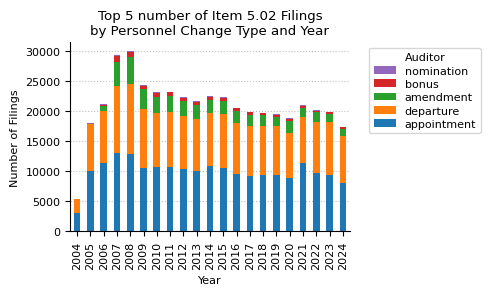

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))

changeType_year_pivot.head(5).drop(columns="total").T.plot(
    kind="bar", stacked=True, ax=ax
)

ax.set_title("Top 5 number of Item 5.02 Filings\nby Personnel Change Type and Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Changes")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()  # reverse order of legend items

ax.legend(
    [h for h in reversed(handles)],
    [l for l in reversed(labels)],
    title="Auditor",
    bbox_to_anchor=(1.05, 1),
    labelspacing=0.3,
    fontsize=8,
)

plt.tight_layout()
plt.show()

## Appointed Positions

In [18]:
appointments = structured_data[structured_data["type"] == "appointment"].copy()

ceo_patterns = ["ceo", "chief executive officer"]
# check if one of these pattersn is in the array in the 'positions' column, set values to NaN if there is an error
appointments.loc[:,"isCEO"] = appointments["positions"].apply(
    lambda x: any([pattern in str(x).lower() for pattern in ceo_patterns]) if isinstance(x, str) else False
)   
board_patterns = ["board", "director", "chairman"]
appointments.loc[:,"isBoardMember"] = appointments["positions"].apply(
    lambda x: any([pattern in str(x).lower() for pattern in board_patterns]) if isinstance(x, str) else False
)

appointments.loc[:, "isOther"] = ~appointments["isCEO"] & ~appointments["isBoardMember"]

# Assign roles based on conditions
appointments.loc[:, "role"] = appointments.apply(
    lambda row: "CEO" if row["isCEO"] else ("Board Member" if row["isBoardMember"] else "Other"),
    axis=1
)

In [19]:
appointments_role_year = appointments.groupby(["role", "year"]).size().unstack().fillna(0)
appointments_role_year.loc["total"] = appointments_role_year.sum()

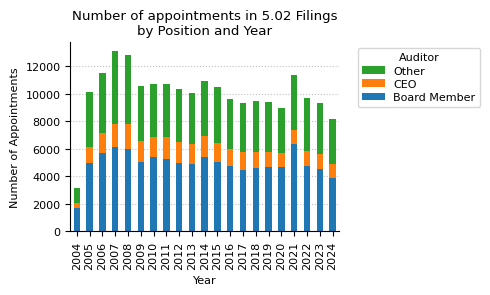

In [77]:
fig, ax = plt.subplots(figsize=(5, 3))

appointments_role_year.T.drop(columns="total").plot(kind="bar", stacked=True, ax=ax)

ax.set_title("Number of appointments in 5.02 Filings\nby Position and Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Appointments")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()  # reverse order of legend items

ax.legend(
    [h for h in reversed(handles)],
    [l for l in reversed(labels)],
    title="Auditor",
    bbox_to_anchor=(1.05, 1),
    labelspacing=0.3,
    fontsize=8,
)

plt.tight_layout()
plt.show()

## Compensation

In this section we analyze the compensation for new appointments including

- one-time payments
- annual cash values
- equity compensation


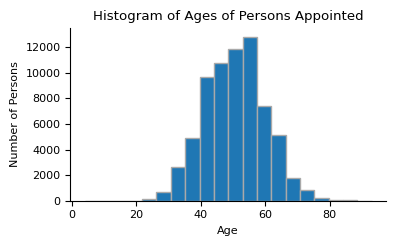

Average Age: 50.51
Min Age: 20.00
Max Age: 93.00
Median Age: 50.00


In [21]:
appointments = structured_data[structured_data["type"] == "appointment"]

fig, ax = plt.subplots(figsize=(4, 2.5))
ax.hist(appointments["person.age"].dropna(), bins=20, edgecolor="darkgrey")
ax.set_title("Histogram of Ages of Persons Appointed")
ax.set_xlabel("Age")
ax.set_ylabel("Number of Persons")
ax.grid(axis="y")
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

# exclude outliers below 18 and above 100
appointments = appointments[
    (appointments["person.age"] >= 18) & (appointments["person.age"] < 100)
]

mean_age = appointments["person.age"].mean()
min_age = appointments["person.age"].min()
max_age = appointments["person.age"].max()
median_age = appointments["person.age"].median()

print(f"Average Age: {mean_age:.2f}")
print(f"Min Age: {min_age:.2f}")
print(f"Max Age: {max_age:.2f}")
print(f"Median Age: {median_age:.2f}")

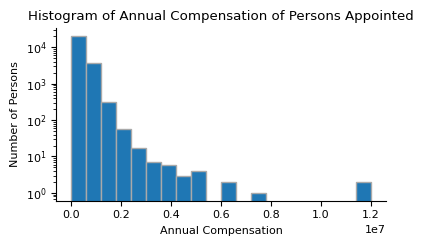

Average Compensation: 382863.76
Min Compensation: 0.00
Max Compensation: 12000000.00
Median Compensation: 330000.00


In [22]:
fig, ax = plt.subplots(figsize=(4, 2.5))

# convert the amounts to numbers, stripping dollar signs
compensation_annual = pd.to_numeric(
    appointments["compensation.annual"].str.replace(r"[\$,]", "", regex=True),
    errors="coerce",
).dropna()

ax.hist(compensation_annual, bins=20, edgecolor="darkgrey")
ax.set_title("Histogram of Annual Compensation of Persons Appointed")
ax.set_xlabel("Annual Compensation")
ax.set_ylabel("Number of Persons")
ax.set_yscale("log")
ax.grid(axis="y")
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

# exclude outliers below 0 and above 1e7
# appointments = appointments[(appointments["compensation.annual"] >= 0) & (appointments["compensation.annual"] < 1e7)]

mean_compensation = compensation_annual.mean()
min_compensation = compensation_annual.min()
max_compensation = compensation_annual.max()
median_compensation = compensation_annual.median()

print(f"Average Compensation: {mean_compensation:.2f}")
print(f"Min Compensation: {min_compensation:.2f}")
print(f"Max Compensation: {max_compensation:.2f}")
print(f"Median Compensation: {median_compensation:.2f}")

In [23]:
# check how many compensations have an equity component
numEquityComponent = appointments["compensation.equity"].notnull().sum()

print(
    f"Appointments with including equity component in the Item 5.02 filings (2004 - 2024):"
)
print(
    f"Number of appointments with an equity component: {numEquityComponent:,} = {numEquityComponent / len(appointments):.1%} of all appointments."
)

Appointments with including equity component in the Item 5.02 filings (2004 - 2024):
Number of appointments with an equity component: 20,801 = 30.1% of all appointments.


## Departures


In [81]:
departures = structured_data[structured_data["type"] == "departure"]
departureType_year = structured_data[
    ["departureType", "year", "accessionNo", "disagreements"]
].explode("departureType")

departureType_year_pivot = pd.pivot_table(
    departureType_year,
    index="departureType",
    columns="year",
    values="accessionNo",
    aggfunc="count",
    fill_value=0,
)

departureType_year_pivot["total"] = departureType_year_pivot.sum(axis=1)
departureType_year_pivot = departureType_year_pivot.sort_values(
    by="total", ascending=False
)

departureType_year_pivot

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,total
departureType,,,,,,,,,,,,,,,,,,,,,
resignation,1578,5304,5670,7297,7855,6438,5833,5898,5574,5287,...,4704,4595,4348,4303,3989,3956,4250,4623,4031,105922
other,314,1098,1384,1840,1683,1529,1642,1637,1452,1645,...,1917,1823,1908,1982,1803,1937,2377,2200,1949,35712
retirement,282,996,1087,1381,1363,1075,1011,1132,1236,1260,...,1266,1270,1400,1403,1217,1372,1338,1368,1207,25289
termination,68,208,293,500,611,619,390,404,475,397,...,409,372,364,319,312,229,355,566,413,8037


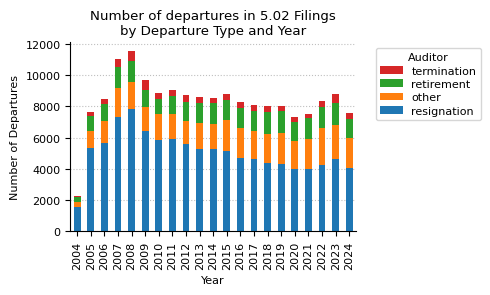

In [82]:
fig, ax = plt.subplots(figsize=(5, 3))

departureType_year_pivot.drop(columns="total").T.plot(kind="bar", stacked=True, ax=ax)

ax.set_title("Number of departures in 5.02 Filings\nby Departure Type and Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Departures")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()  # reverse order of legend items

ax.legend(
    [h for h in reversed(handles)],
    [l for l in reversed(labels)],
    title="Auditor",
    bbox_to_anchor=(1.05, 1),
    labelspacing=0.3,
    fontsize=8,
)

plt.tight_layout()
plt.show()

(array([-5.,  0.,  5., 10., 15., 20., 25.]),
 [Text(-5.0, 0, '2021'),
  Text(0.0, 0, '2004'),
  Text(5.0, 0, '2009'),
  Text(10.0, 0, '2014'),
  Text(15.0, 0, '2019'),
  Text(20.0, 0, '2024'),
  Text(25.0, 0, '')])

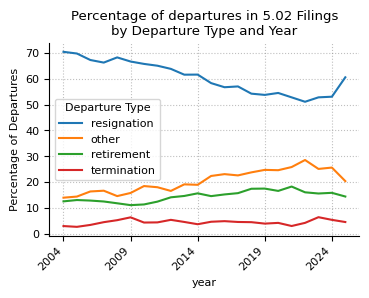

In [83]:
percentag_departure_pivot = departureType_year_pivot.copy()
percentag_departure_pivot.loc["total"] = percentag_departure_pivot.sum(axis=0)
percentag_departure_pivot = (
    percentag_departure_pivot.div(percentag_departure_pivot.loc["total"], axis=1) * 100
)
percentag_departure_pivot.drop("total")


fig, ax = plt.subplots(figsize=(4, 2.5))
percentag_departure_pivot.drop("total").T.plot(kind="line", stacked=False, ax=ax)
ax.legend(title="Departure Type")
ax.set_ylabel("Percentage of Departures")
ax.set_title("Percentage of departures in 5.02 Filings\nby Departure Type and Year")
plt.xticks(rotation=45, ha="right")

## Departures connected to disagreements


In [84]:
disagreements_year_pivot = departures.pivot_table(
    # departures,
    index="year",
    values=["disagreements"],
    aggfunc=lambda x: (x == True).sum(),
    fill_value=0,
)

departures_year_pivot = departures.pivot_table(
    index="year",
    values=["accessionNo"],
    aggfunc="count",
    fill_value=0,
)

disagreements_year_pivot = disagreements_year_pivot.T
disagreements_year_pivot["total"] = disagreements_year_pivot.sum(axis=1)
disagreements_year_pivot = disagreements_year_pivot.sort_values(
    by="total", ascending=False
)
disagreements_year_pivot

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,total
disagreements,25,61,84,87,103,90,81,54,61,48,...,65,57,44,32,45,17,70,46,47,1211


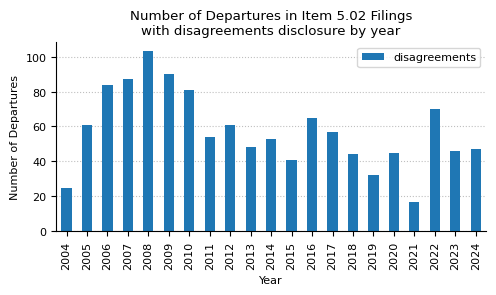

In [85]:
fig, ax = plt.subplots(figsize=(5, 3))

disagreements_year_pivot.T.drop("total").plot(kind="bar", stacked=False, ax=ax)

ax.set_title("Number of Departures in Item 5.02 Filings\nwith disagreements disclosure by year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Departures")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()  # reverse order of legend items

labels = [
    "declination" if label == "declination to stand for reappointment" else label
    for label in labels
]


plt.tight_layout()
plt.show()

In [45]:
disagreements_year_pivot = departures.pivot_table(
    # departures,
    index="year",
    values=["disagreements"],
    aggfunc=lambda x: (x == True).sum(),
    fill_value=0,
)

departures_year_pivot = departures.pivot_table(
    index="year",
    values=["accessionNo"],
    aggfunc="count",
    fill_value=0,
).rename(columns={"accessionNo": "departures"})

percentage_disagreements = (
    disagreements_year_pivot["disagreements"]
    / departures_year_pivot["departures"]
    * 100
).fillna(0)
percentage_disagreements = percentage_disagreements.apply(lambda x: f"{x:.2f}")

departures_year_pivot["disagreements"] = disagreements_year_pivot["disagreements"]
departures_year_pivot["disagreements_percentage"] = percentage_disagreements
departures_year_pivot


,departures,disagreements,disagreements_percentage
year,,,
2004,2273,25,1.10
2005,7731,61,0.79
2006,8578,84,0.98
2007,11211,87,0.78
2008,11687,103,0.88
2009,9800,90,0.92
2010,9031,81,0.90
2011,9247,54,0.58
2012,8901,61,0.69


## Amendments

This section includes statistics of amendments of contracts.
First we will investigate boolean statistics and then analyze which part of the compensation was changed.

In [30]:
amendments = structured_data[structured_data["type"] == "amendment"]
columns_to_check_amendments = [
    "termShortened",
    "termExtended",
    "compensationIncreased",
    "compensationDecreased",
]
amendments_summary = (
    amendments[columns_to_check_amendments]
    .apply(lambda x: x.value_counts())
    .T.fillna(0)
    .astype(int)
)
amendments_summary["False % tot."] = (
    (amendments_summary[False] / len(amendments)) * 100
).map("{:.2f}".format)
amendments_summary["True % tot."] = (
    (amendments_summary[True] / len(amendments)) * 100
).map("{:.2f}".format)
print(f"Summary of the {len(amendments)} amendments in Item 5.02 filings (2004 - 2024).")
amendments_summary

Summary of the 41789 amendments in Item 5.02 filings (2004 - 2024).


,False,True,False % tot.,True % tot.
termShortened,804,98,1.92,0.23
termExtended,731,3974,1.75,9.51
compensationIncreased,925,5077,2.21,12.15
compensationDecreased,876,1040,2.10,2.49


In [31]:
amendments = structured_data[structured_data["type"] == "amendment"]
columns_to_check_amendments = ["compensation.onetime", "compensation.annual", "compensation.equity"]
compensation_summary = amendments[columns_to_check_amendments].count().astype(int)
percentage_summary = (compensation_summary / len(amendments) * 100).round(2)
amendments_summary_df = pd.DataFrame([compensation_summary, percentage_summary], index=["Count", "Percentage"]).T
amendments_summary_df["Count"] = amendments_summary_df["Count"].astype(int)
amendments_summary_df

,Count,Percentage
compensation.onetime,1979,4.74
compensation.annual,18403,44.04
compensation.equity,9202,22.02


## Organizational Changes

In this section we have a look at reported organizational changes.

In [32]:
keys = [
    "organ",
    "sizeIncrease",
    "sizeDecrease",
    "created",
    "abolished",
    "affectedPersonnel",
]
column_names_orig = [f"organizationChanges.{k}" for k in keys]
meta_keys = [
    "accessionNo",
    "filedAt",
    "periodOfReport",
    "formType",
    "cik",
    "ticker",
    "companyName",
    "year"
]
organizationChanges = structured_data[meta_keys + column_names_orig].rename(
    {old: new for old, new in zip(column_names_orig, keys)}, axis=1
)
# we exploded the personnel changes to arrive at the current dataframe, so now we need to drop duplicates to get the unique filings
organizationChanges = organizationChanges.drop_duplicates(subset=["cik", "accessionNo"])

organizationChanges.dropna(subset=keys, how="all", inplace=True)
print(f"There are {len(organizationChanges):,} unique Form 8-K filings with a disclosed organization change.")
organizationChanges


There are 39,337 unique Form 8-K filings with a disclosed organization change.


,accessionNo,filedAt,periodOfReport,formType,cik,ticker,companyName,year,organ,sizeIncrease,sizeDecrease,created,abolished,affectedPersonnel
4,0000899715-04-000164,2004-08-23T12:35:47-04:00,2004-08-23,8-K,899715,SKT,TANGER FACTORY OUTLET CENTERS INC,2004,Board of Directors,True,NaN,NaN,NaN,['Allan L. Schuman']
31,0001193125-04-145794,2004-08-24T16:08:25-04:00,2004-08-20,8-K,109657,GTBP,OXIS INTERNATIONAL INC,2004,Board of Directors,True,NaN,NaN,NaN,"['Marvin S. Hausman, MD']"
40,0000950137-04-007089,2004-08-25T12:16:29-04:00,2004-08-23,8-K,1032067,MEAD,MEADE INSTRUMENTS CORP,2004,Board of Directors,True,NaN,NaN,NaN,NaN
45,0000066756-04-000085,2004-08-25T14:12:52-04:00,2004-08-24,8-K,66756,ALE,ALLETE INC,2004,Board of Directors,False,False,NaN,NaN,NaN
59,0001104659-04-025731,2004-08-26T09:08:33-04:00,2004-08-24,8-K,1260167,NaN,WORLDSPAN L P,2004,Board of Directors,NaN,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473434,0000950170-24-135784,2024-12-12T16:10:08-05:00,2024-12-10,8-K,1590955,PAYC,"Paycom Software, Inc.",2024,Board of Directors,True,NaN,NaN,NaN,NaN
473447,0000950170-24-135822,2024-12-12T16:30:08-05:00,2024-12-06,8-K,1541157,AKTX,Akari Therapeutics Plc,2024,Board of Directors,NaN,NaN,NaN,NaN,NaN
473471,0001830188-24-000039,2024-12-12T17:20:58-05:00,2024-12-12,8-K,1830188,UHG,"United Homes Group, Inc.",2024,Board of Directors,NaN,True,NaN,NaN,['Robert Grove']
473484,0001868275-24-000078,2024-12-13T08:00:27-05:00,2024-12-09,8-K,1868275,CEG,Constellation Energy Corp,2024,Board of Directors,True,NaN,NaN,NaN,"['Eileen Paterson', 'Peter Oppenheimer']"


In [33]:
organizationChanges["organ"].value_counts().head()

organ
Board of Directors        31691
Compensation Committee      452
Audit Committee             401
Board of Trustees           251
Equity Incentive Plan       228
Name: count, dtype: int64

In [34]:
board_changes = organizationChanges[organizationChanges["organ"] == "Board of Directors"].copy()

# Define classification function
def classify_size_change(row):
    
    if row["sizeIncrease"]:
        return "increase"
    elif row["sizeDecrease"]:
        return "decrease"
    else:
        return "no size change"
    
board_changes["sizeChange"] = board_changes.apply(classify_size_change, axis=1)

print("Size changes of the Board of Directors disclosed in Item 5.02 over the full period (2004 - 2024).")
print(board_changes["sizeChange"].value_counts())

Size changes of the Board of Directors disclosed in Item 5.02 over the full period (2004 - 2024).
sizeChange
increase          25523
no size change     5471
decrease            697
Name: count, dtype: int64


In [35]:
counts_board_size_change_yr_piv = (
    board_changes.drop_duplicates(subset=["accessionNo"])
    .groupby(["year", "sizeChange"])
    .size()
    .unstack()
    .fillna(0)
).astype(int)
print(f"Size changes of the Board of Directors disclosed in Item 5.02 filings by year (2004 - 2024).")
counts_board_size_change_yr_piv.T

Size changes of the Board of Directors disclosed in Item 5.02 filings by year (2004 - 2024).


year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
sizeChange,,,,,,,,,,,,,,,,,,,,,
decrease,4,12,20,35,28,32,14,29,21,32,...,43,29,40,39,40,41,44,51,58,58
increase,296,983,1132,1229,1275,1107,1136,1183,1234,1226,...,1249,1279,1259,1304,1276,1335,1648,1417,1394,1252
no size change,21,100,141,286,352,294,297,281,252,268,...,281,249,280,247,308,309,281,330,329,301


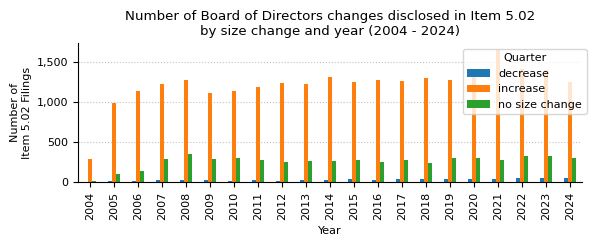

In [36]:
counts_bsc_yr = counts_board_size_change_yr_piv.stack().reset_index(name="count")

fig, ax = plt.subplots(figsize=(6, 2.5))
counts_board_size_change_yr_piv.plot(kind="bar", ax=ax, legend=True)
ax.legend(title="Quarter", loc="upper right", bbox_to_anchor=(1.02, 1))
ax.set_title("Number of Board of Directors changes disclosed in Item 5.02\nby size change and year (2004 - 2024)")
ax.set_xlabel("Year")
ax.set_ylabel("Number of\nItem 5.02 Filings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

## Bonus Plans

This section gives a quick overview of the bonus plans reported in the Item 5.02 filings.

For this section, we downloaded all filings including a bonus plan change from the [Form 8-K Item 5.02 Structured Data API](https://sec-api.io/docs/form-8k-data-item5-2-search-api) and prepared a second dataframe.
For this, we exploded the list of bonus plans and saved it to disk. This way, we can start with the analysis right away.

In [43]:
# data loading goes here
unique_years = structured_data_bonus["year"].nunique()
unique_companies = structured_data_bonus["companyName"].nunique()
unique_filings = structured_data_bonus["accessionNo"].nunique()
min_year = structured_data_bonus["year"].min()
max_year = structured_data_bonus["year"].max()
print("Loaded dataframe with bonus plan disclosure data from Form 8-K Item 5.02 filings")
print(f"Number of filings: {unique_filings:,}")
print(f"Number of records: {len(structured_data_bonus):,}")
print(f"Number of years: {unique_years:,} ({min_year}-{max_year})")
print(f"Number of unique companies: {unique_companies:,}")
structured_data_bonus.head()

Loaded dataframe with structured personnel change data from Form 8-K Item 5.02 filings
Number of filings: 46,542
Number of records: 46,542
Number of years: 21 (2004-2024)
Number of unique companies: 11,044


,accessionNo,filedAt,periodOfReport,formType,cik,ticker,companyName,items,attachments,organizationChanges.organ,...,compensation.equity,compensation.equityDetails,specificRoles,generalEmployee,eligibleRoles,year,month,qtr,filedAt_local,filedAtClass
4,0001104659-04-025325,2004-08-23T16:14:05-04:00,2004-08-17,8-K,1003214,SIMG,SILICON IMAGE INC,['Item 1.01: Entry into a Material Definitive ...,"['Amended and Restated Employment Agreement, d...",NaN,...,NaN,NaN,NaN,NaN,NaN,2004,8,3,2004-08-23 16:14:05,afterMarket
58,0000950123-04-010249,2004-08-26T17:01:01-04:00,2004-08-23,8-K,784681,NaN,CSC HOLDINGS INC,['Item 5.02: Departure of Directors or Certain...,NaN,NaN,...,"Annual awards of 10,000 restricted shares of C...",Four-year cliff vesting,NaN,NaN,NaN,2004,8,3,2004-08-26 17:01:01,afterMarket
162,0000703701-04-000042,2004-09-01T17:26:39-04:00,2004-09-01,8-K,703701,AASR,ASCENT ASSURANCE INC,['Item 1.01: Entry into a Material Definitive ...,['Employment Agreement'],NaN,...,Options to purchase 9.9% of the common stock,Vesting over 5 years,NaN,NaN,NaN,2004,9,3,2004-09-01 17:26:39,afterMarket
170,0001204560-04-000031,2004-09-02T11:44:59-04:00,2004-09-01,8-K,1204560,MPG,MAGUIRE PROPERTIES INC,['Item 5.02: Departure of Directors or Certain...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2004,9,3,2004-09-02 11:44:59,marketHours
255,0001104659-04-027002,2004-09-07T17:22:24-04:00,2004-08-31,8-K,1233426,NHRX,MILLSTREAM ACQUISITION CORP,['Item 1.01: Entry into a Material Definitive ...,['Form 8-K'],Board of Directors,...,"30,000 stock options",25% vesting immediately with an additional 25%...,False,False,NaN,2004,9,3,2004-09-07 17:22:24,afterMarket


In [48]:
bool_variables_to_analyze = [
"specificRoles",
"generalEmployee",
"specificIndividuals",
"conditional"
]

var_to_label = {
    "specificRoles": "Specific Positions are eligible",
    "generalEmployee": "General Employees are eligible",
    "specificIndividuals": "Specific Individuals are eligible",
    "conditional": "Conditional Bonus"
}


total_samples = len(structured_data_bonus)
# Create a row for the total samples
total_row = pd.DataFrame(
    {
        "Samples": [f"{total_samples:,.0f}"],
        "Pct.": [""],
        "Pct. tot.": [100],
    },
    index=pd.MultiIndex.from_tuples([("Total", "")], names=["Variable", "Value"]),
)


bool_variables_stats = []

for variable in bool_variables_to_analyze:
    variable_stats = (
        structured_data_bonus[variable]
        .value_counts()
        .to_frame()
        .reset_index()
        .rename(columns={variable: "value"})
    )
    variable_stats = variable_stats.sort_values(by="value", ascending=False)
    variable_stats["pct"] = (
        variable_stats["count"] / variable_stats["count"].sum() * 100
    ).round(1)
    variable_stats["pct_tot"] = (variable_stats["count"] / total_samples * 100).round(1)
    variable_stats.index = pd.MultiIndex.from_tuples(
        [(variable, row["value"]) for _, row in variable_stats.iterrows()],
    )
    variable_stats.drop(columns="value", inplace=True)

    bool_variables_stats.append(variable_stats)

bool_variables_stats = pd.concat(bool_variables_stats, axis=0)
bool_variables_stats.index.set_names(["Variable", "Value"], inplace=True)
bool_variables_stats.rename(
    index=var_to_label,
    columns={"count": "Samples", "pct": "Pct.", "pct_tot": "Pct. tot."},
    inplace=True,
)
bool_variables_stats["Samples"] = bool_variables_stats["Samples"].apply(
    lambda x: f"{x:,.0f}"
)


bool_variables_stats = pd.concat([total_row, bool_variables_stats])


print(
    f"Number of Bonus Plans disclosed in Item 5.02\nby their disclosed characteristics (2004 - 2024):"
)
bool_variables_stats

Number of Bonus Plans disclosed in Item 5.02
by their disclosed characteristics (2004 - 2024):


Samples  Pct.  Pct. tot.
Variable                          Value                         
Total                                    46,542            100.0
Specific Positions are eligible   True    8,457  26.9       18.2
                                  False  23,004  73.1       49.4
General Employees are eligible    True    6,398  22.7       13.7
                                  False  21,746  77.3       46.7
Specific Individuals are eligible True   29,934  68.9       64.3
                                  False  13,542  31.1       29.1
Conditional Bonus                 True   30,314  77.9       65.1
                                  False   8,604  22.1       18.5

In [56]:
columns_to_check_bonus = ["compensation.cash", "compensation.equity"]
compensation_summary = structured_data_bonus[columns_to_check_bonus].count().astype(int)
percentage_summary = (compensation_summary / len(structured_data_bonus) * 100).round(2)
bonus_summary_df = pd.DataFrame([compensation_summary, percentage_summary], index=["Count", "Percentage"]).T
bonus_summary_df["Count"] = bonus_summary_df["Count"].astype(int)
bonus_summary_df.rename(columns={"Count": "Total Count", "Percentage": "Share (%)"}, inplace=True)
bonus_summary_df = bonus_summary_df.rename(index={"compensation.cash": "Cash Compensation",
                                                  "compensation.equity": "Equity Compensation"})
print("Number of Bonus Plans disclosed in Item 5.02 filings (2004 - 2024) with compensation details.")
bonus_summary_df

Number of Bonus Plans disclosed in Item 5.02 filings (2004 - 2024) with compensation details.


,Total Count,Share (%)
Cash Compensation,26946,57.90
Equity Compensation,24963,53.64
